In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ia0_ds40
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ia0_ds40
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow.compat.v2 as tf
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit

# from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList =['s03']
#List of subjects

In [ ]:

def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/MyDrive/eeg dataset/" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        np.save('/content/drive/MyDrive/eeg dataset' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/MyDrive/eeg dataset' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (15616, 70) (15616, 4)
testing dataset: (3904, 70) (3904, 4)


In [ ]:
with open('/content/drive/My Drive/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('/content/drive/My Drive/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
X.shape

(15616, 70)

In [ ]:
X.ndim

2

In [ ]:
Y.shape

(15616, 4)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_train.ndim

2

In [ ]:
x_train = np.array(X[:])

In [ ]:
with open('/content/drive/My Drive/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open('/content/drive/My Drive/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(15616, 70, 1)

In [ ]:
batch_size = 256
num_classes = 8
epochs = 70
input_shape=(x_train.shape[1], 1)

In [ ]:
x_train.shape[1]

70

In [ ]:
print(input_shape)

(70, 1)


In [ ]:
y_train.shape

(15616, 8)

In [ ]:
y_train.shape[1]

8

In [ ]:
y=(y_train[1],1)

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:

!pip install git+https://github.com/forrestbao/pyeeg.git



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-dtsifhkv
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-dtsifhkv
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2


In [ ]:
from keras.layers.convolutional import Conv1D

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.layers.attention.attention import Attention

from keras.regularizers import l2
from  keras.layers  import  Bidirectional
from keras.models import Sequential


from keras import backend as K
from keras.engine.base_layer import Layer
from keras import activations
import numpy as np


class TDNNLayer(Layer):


    def __init__(self,
                 input_context=[-2, 2],
                 sub_sampling=False,
                 initializer='uniform',
                 activation=None,
                 **kwargs):

        self.input_context = input_context
        self.sub_sampling = sub_sampling
        self.initializer = initializer
        self.activation = activations.get(activation)
        self.mask = None
        self.kernel = None
        super(TDNNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        kernel_shape = (self.input_context[1]-self.input_context[0]+1, 1, 1)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.initializer,
                                      trainable=True)
        self.mask = np.zeros(kernel_shape)
        self.mask[0][0][0] = 1
        self.mask[self.input_context[1]-self.input_context[0]][0][0] = 1

        if self.sub_sampling:
            self.kernel = self.kernel * self.mask

        super(TDNNLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self,
             inputs,
             mask=None,
             training=None,
             initial_state=None,
             constants=None):
        if self.sub_sampling:
            output = K.conv1d(inputs,
                              self.kernel,
                              strides=1,
                              padding="same",
                              )
        else:
            masked_kernel = self.kernel * self.mask
            output = K.conv1d(inputs,
                              masked_kernel,
                              strides=1,
                              padding="same",
                              )
        if self.activation is not None:
            return self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1]-self.input_context[1]+self.input_context[0]

model = Sequential()
model.add(TDNNLayer())
model.add(TDNNLayer())
model.add(TDNNLayer())

model.add(Dense(units = 124))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(384, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))









In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/70
61/61 [==============================] - 25s 361ms/step - loss: 1.4935 - accuracy: 0.3631 - val_loss: 1.4307 - val_accuracy: 0.3747
Epoch 2/70
61/61 [==============================] - 28s 452ms/step - loss: 1.4221 - accuracy: 0.3761 - val_loss: 1.3805 - val_accuracy: 0.4421
Epoch 3/70
61/61 [==============================] - 16s 256ms/step - loss: 1.2700 - accuracy: 0.4679 - val_loss: 1.2408 - val_accuracy: 0.5133
Epoch 4/70
61/61 [==============================] - 15s 243ms/step - loss: 1.1169 - accuracy: 0.5451 - val_loss: 1.0465 - val_accuracy: 0.5753
Epoch 5/70
61/61 [==============================] - 15s 252ms/step - loss: 1.0172 - accuracy: 0.5847 - val_loss: 0.9893 - val_accuracy: 0.5861
Epoch 6/70
61/61 [==============================] - 15s 252ms/step - loss: 0.9653 - accuracy: 0.6064 - val_loss: 0.9419 - val_accuracy: 0.6091
Epoch 7/70
61/61 [==============================] - 15s 252ms/step - loss: 0.8963 - accuracy: 0.6372 - val_loss: 0.8355 - val_accuracy: 0.6606

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

122/122 [==============================] - 2s 13ms/step - loss: 0.1305 - accuracy: 0.9603
Test loss: 0.1304970234632492
Test accuracy: 0.9602971076965332


In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy

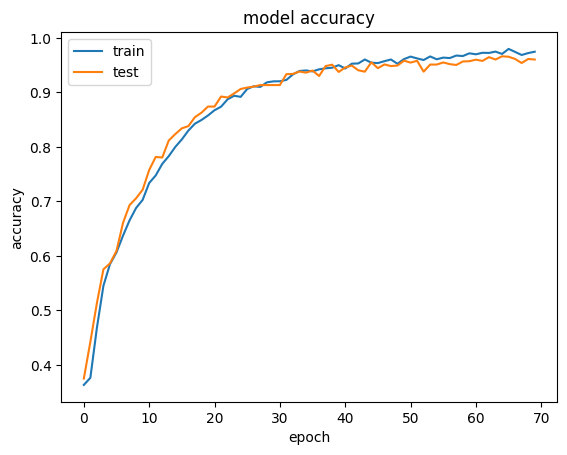

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

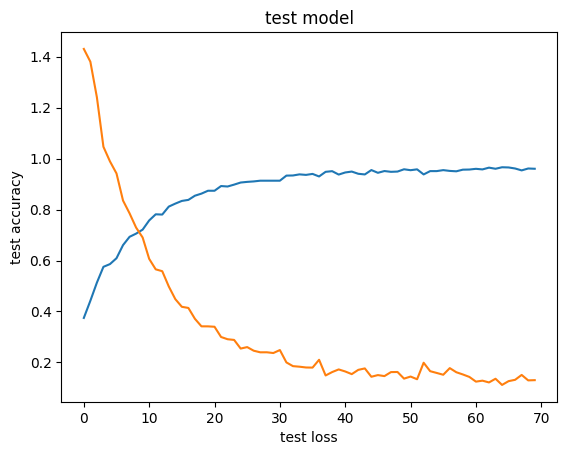

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [ ]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
y_test[1]

In [ ]:
y_pred[1]

In [ ]:
y_test1=np.argmax(y_test, axis=1)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_test1[1]

In [ ]:
y_pred[1]

In [ ]:
cmatrix=confusion_matrix(y_test1, y_pred)

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd

In [ ]:
print(classification_report(y_test1, y_pred))
